### 🔍 Objetivo
Construir um modelo de classificação que detecte intrusões em sistemas. A métrica principal é o F1-score, com foco também em explicabilidade (interpretabilidade dos resultados).

In [1]:
# 1. Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import shap
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

C:\Users\henri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 2. Carregamento dos dados
df = pd.read_csv("data/ERENO-2.0-100K.csv")
df.columns = df.columns.str.strip()
df = df.dropna(subset=['class'])
df['class'] = df['class'].astype('category')

In [3]:
# Visualização inicial dos dados
df.head()

,Time,isbA,isbB,isbC,vsbA,vsbB,vsbC,isbARmsValue,isbBRmsValue,isbCRmsValue,...,sqDiff,gooseLengthDiff,cbStatusDiff,apduSizeDiff,frameLengthDiff,timestampDiff,tDiff,timeFromLastChange,delay,class
0,0.03885,-0.026538,-0.035877,0.060486,-0.039338,0.077393,-0.038062,0.029459,0.025651,0.029991,...,0.0,0.0,0.0,0.0,0.0,0.005068,0.000000,0.022390,0.000130,grayhole
1,0.03885,-0.026538,-0.035877,0.060486,-0.039338,0.077393,-0.038062,0.029459,0.025651,0.029991,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.022390,0.000130,normal
2,0.37464,0.029923,-0.076646,0.045858,-0.095898,0.055355,0.040523,0.048988,0.053399,0.052915,...,86.0,0.0,1.0,0.0,0.0,0.335783,97.634223,-97.276050,0.000123,injection
3,0.50337,0.432347,-0.113172,-0.138316,0.014902,0.082498,-0.079844,0.154143,0.057803,0.062056,...,-67.0,0.0,1.0,0.0,0.0,0.128662,6302.515166,-6399.662553,0.000055,high_StNum
4,0.7602,0.106018,-0.152017,0.015963,-0.070272,-0.022661,0.092251,0.110327,0.108409,0.071887,...,42.0,0.0,0.0,0.0,0.0,0.256906,519.062125,-6918.467772,0.000131,high_StNum


### 🔍 Visualização inicial das classes

Índice: 0 -> Classe: grayhole | Quantidade: 19999
Índice: 1 -> Classe: high_StNum | Quantidade: 20000
Índice: 2 -> Classe: injection | Quantidade: 20000
Índice: 3 -> Classe: inverse_replay | Quantidade: 20000
Índice: 4 -> Classe: masquerade_fake_fault | Quantidade: 20000
Índice: 5 -> Classe: masquerade_fake_normal | Quantidade: 20000
Índice: 6 -> Classe: normal | Quantidade: 39999
Índice: 7 -> Classe: poisoned_high_rate | Quantidade: 20000
Índice: 8 -> Classe: random_replay | Quantidade: 20000
Total de registros: 199998


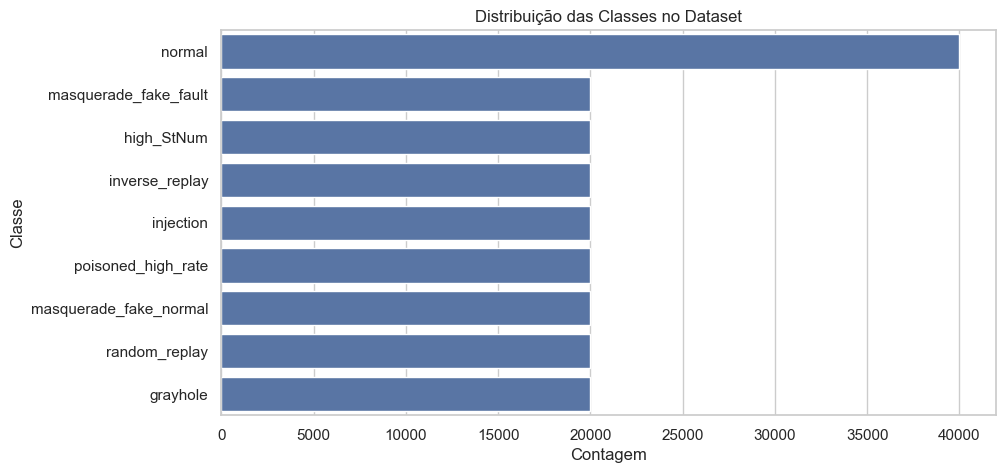

In [4]:
X = df.drop(columns=['class'])
y = df['class']

# Imprimir cada classe, seu índice e a quantidade de registros
class_counts = y.value_counts().sort_index()
for idx, classe in enumerate(y.cat.categories):
    print(f"Índice: {idx} -> Classe: {classe} | Quantidade: {class_counts[idx]}")
print(f"Total de registros: {len(y)}")

plt.figure(figsize=(10,5))
sns.countplot(data=df, y='class', order=df['class'].value_counts().index)
plt.title("Distribuição das Classes no Dataset")
plt.xlabel("Contagem")
plt.ylabel("Classe")
plt.show()

### 🛠️ Pré-processamento dos dados
Transforma as colunas em formato numérico e separa as variáveis de entrada e saída, preparando os dados para o treinamento do modelo de detecção de intrusões.

In [5]:
#  Remover colunas irrelevantes para o modelo
# drop_cols = ['ethDst', 'ethSrc', 'TPID', 'gocbRef', 'datSet', 'goID', 'ethType', 'gooseAppid', 'gooseLen']
# df.drop(columns=drop_cols, inplace=True, errors='ignore')

# Converter a coluna 'test' para string (caso contenha valores mistos)
df['test'] = df['test'].astype(str)

# Codificar a coluna 'test' em valores numéricos usando LabelEncoder
df['test'] = LabelEncoder().fit_transform(df['test'])

# Separar as variáveis independentes (X) e a variável alvo (y)
X = df.drop(columns=['class'])  # X recebe todas as colunas, exceto 'class'
y = df['class']                 # y recebe apenas a coluna 'class'

# Converter todas as colunas de X para tipo numérico
# Caso não seja possível converter algum valor, ele vira NaN
# Em seguida, preenche todos os NaN com zero
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

### ✂️ Divisão e normalização dos dados
Separa os dados em treino e teste e normaliza as variáveis, garantindo que todas as features tenham a mesma escala antes do treinamento do modelo.

In [6]:
# Separa os dados em treino e teste (70% treino, 30% teste)
# O parâmetro stratify=y garante que a proporção das classes seja mantida em ambas as divisões
# random_state=42 garante reprodutibilidade dos resultados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Cria o objeto de normalização (StandardScaler)
# O StandardScaler transforma os dados para que cada feature tenha média 0 e desvio padrão 1
scaler = StandardScaler()

# Ajusta o scaler nos dados de treino e transforma os dados de treino
X_train_scaled = scaler.fit_transform(X_train)

# Usa o mesmo scaler (ajustado nos dados de treino) para transformar os dados de teste
X_test_scaled = scaler.transform(X_test)

### 🎯 Treinamento com Random Forest

In [7]:
model = RandomForestClassifier(
    n_estimators=200,   # número de árvores na floresta
    max_depth=20,       # profundidade máxima de cada árvore
    random_state=42     # semente para reprodutibilidade dos resultados
)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

                        precision    recall  f1-score   support

              grayhole       0.75      0.66      0.70      6000
            high_StNum       1.00      1.00      1.00      6000
             injection       1.00      1.00      1.00      6000
        inverse_replay       1.00      1.00      1.00      6000
 masquerade_fake_fault       1.00      1.00      1.00      6000
masquerade_fake_normal       1.00      1.00      1.00      6000
                normal       0.78      0.89      0.83     12000
    poisoned_high_rate       1.00      1.00      1.00      6000
         random_replay       0.98      0.82      0.89      6000

              accuracy                           0.92     60000
             macro avg       0.94      0.93      0.94     60000
          weighted avg       0.93      0.92      0.92     60000



### 📈 Matriz de confusão

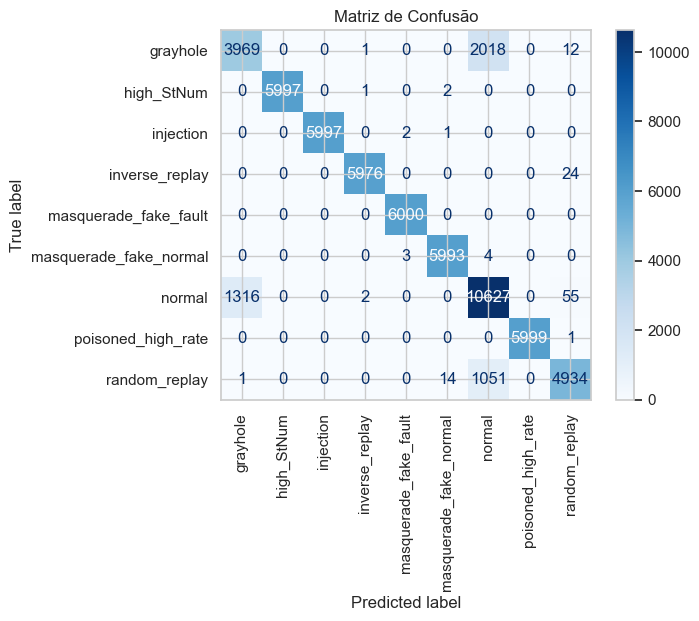

In [8]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=y.cat.categories)
disp.plot(cmap="Blues", xticks_rotation=90)
plt.title("Matriz de Confusão")
plt.show()

### 🔧 Ajuste de Hiperparâmetros com GridSearchCV (exemplo reduzido)

In [9]:
param_grid = {
    'n_estimators': [100, 200], # Número de árvores na floresta
    'max_depth': [10, 20]       # Profundidade máxima de cada árvore
}
grid = GridSearchCV(
    RandomForestClassifier(),   # Modelo a ser ajustado
    param_grid,                 # Grade de parâmetros para testar
    cv=3,                       # Validação cruzada com 3 divisões
    scoring='f1_weighted'       # Métrica de avaliação: F1-score ponderado
)
grid.fit(X_train_scaled, y_train) # Treina o GridSearch nos dados de treino
print("Melhores parâmetros:", grid.best_params_) # Exibe os melhores parâmetros encontrados

Melhores parâmetros: {'max_depth': 20, 'n_estimators': 200}


### 🧠 Explicabilidade com SHAP

### 🐝 Visualização dos impactos das features (Beeswarm plot)
O beeswarm plot mostra como cada feature influencia as predições do modelo, indicando a direção e intensidade do impacto em cada amostra.

100%|===================| 8996/9000 [11:00<00:00]        

Importância média das features (todas as classes)


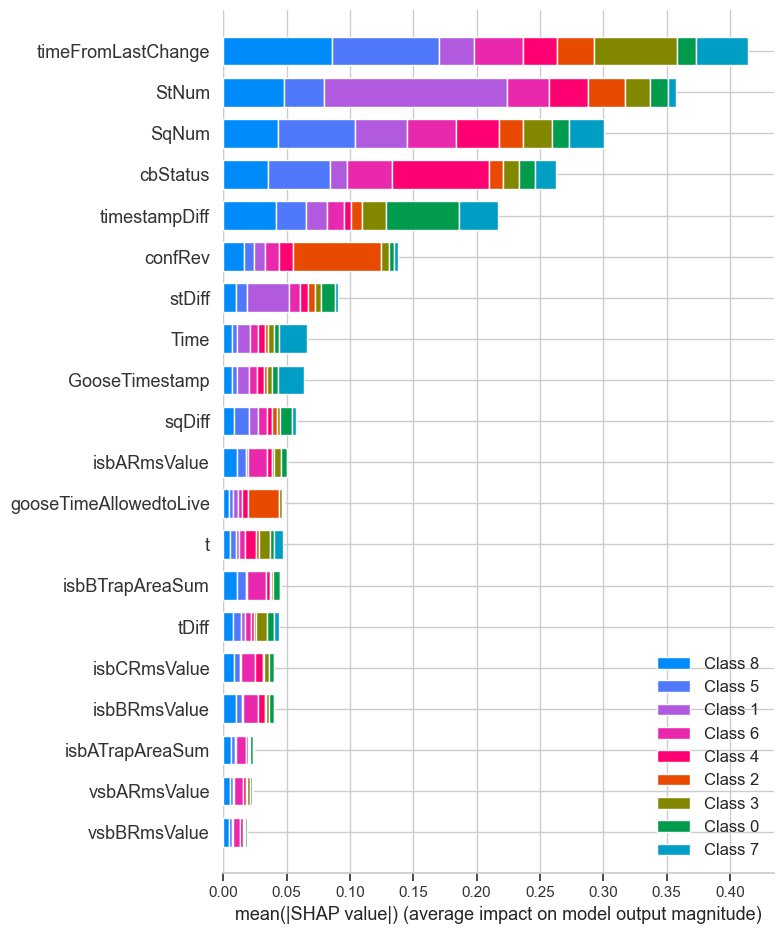

In [10]:
# Explicabilidade global com SHAP (amostra reduzida para 1000 instâncias)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)
X_sample = X_test_scaled_df.iloc[:1000]

explainer = shap.Explainer(model, X_sample)
shap_values = explainer(X_sample, check_additivity=False)

print("Importância média das features (todas as classes)")
shap.summary_plot(shap_values, X_sample, plot_type="bar")

Distribuição dos impactos das features (beeswarm plot) para a classe de índice 1


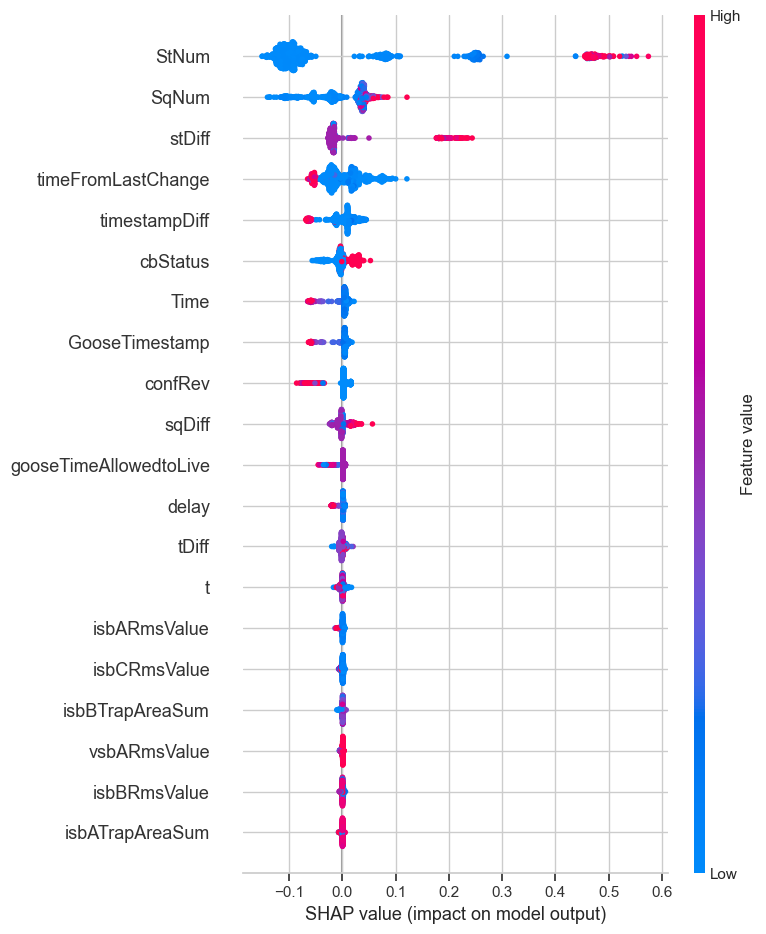

In [25]:
# Visualização detalhada com beeswarm plot para a classe 0
classe_escolhida = 1 # Classe normal
print(f'Distribuição dos impactos das features (beeswarm plot) para a classe de índice {classe_escolhida}')
shap.summary_plot(shap_values.values[:, :, classe_escolhida], X_sample, plot_type="dot")

Explicação local para a amostra 10, classe 6


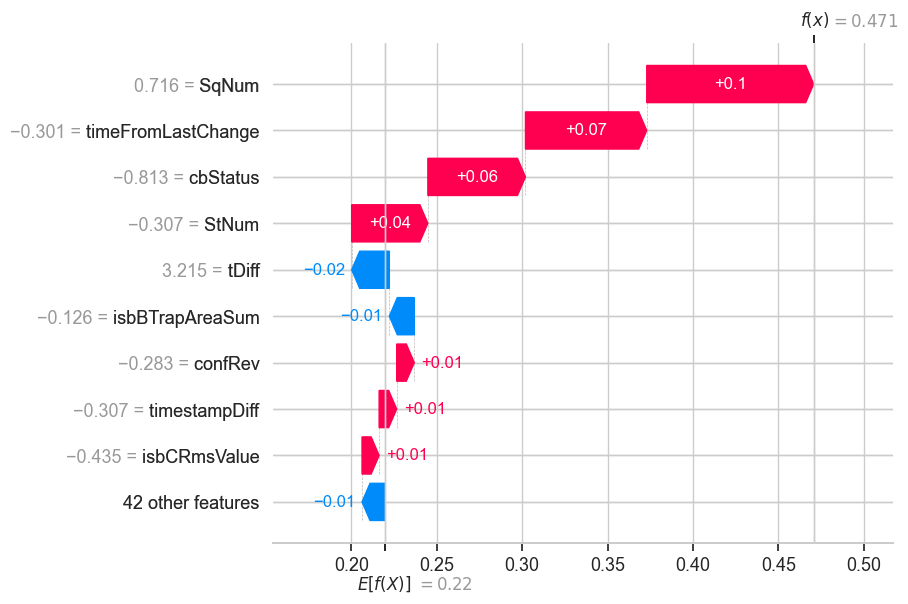

In [23]:
# Explicação local: waterfall plot para uma amostra e classe específica
idx = 10  # índice da amostra
classe_escolhida = 6  # índice da classe desejada
print(f"Explicação local para a amostra {idx}, classe {classe_escolhida}")
shap.plots.waterfall(shap_values[idx, :, classe_escolhida], max_display=10)

### 📊 Explicação local: como o modelo chegou à decisão para uma amostra e classe específica

Esse código mostra, de forma visual e detalhada, como o modelo chegou à decisão para uma amostra específica e uma classe específica, ajudando a entender o "porquê" da predição.

Force plot para a amostra 2, classe 6


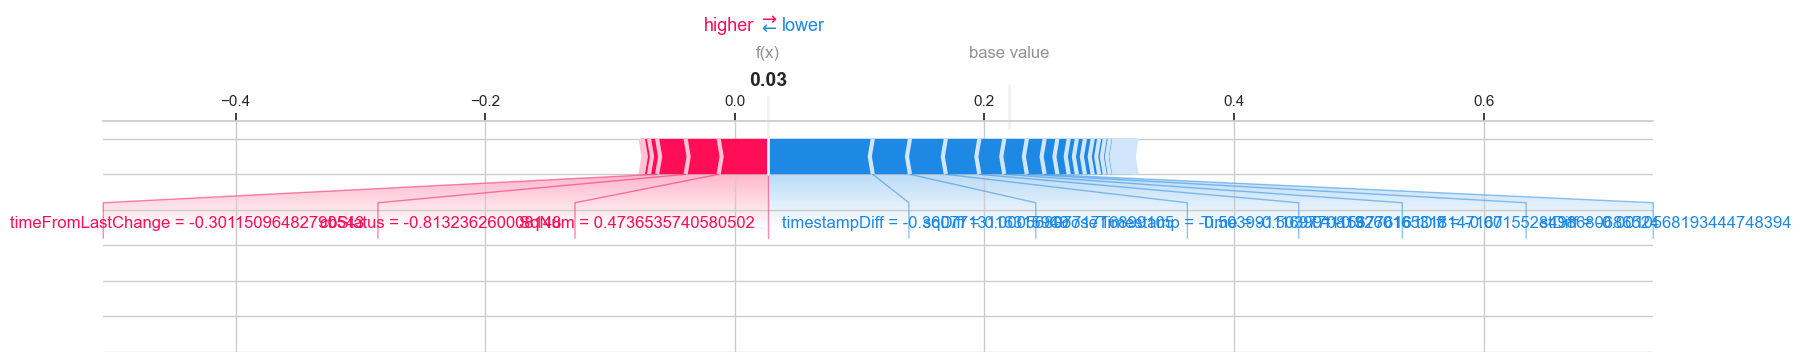

In [13]:
# Explicação local: force plot para uma amostra e classe específica (fundo branco)
idx = 2  # índice da amostra
classe_escolhida = 6  # índice da classe desejada
print(f"Force plot para a amostra {idx}, classe {classe_escolhida}")
shap.plots.force(
    explainer.expected_value[classe_escolhida],
    shap_values.values[idx, :, classe_escolhida],
    X_sample.iloc[idx],
    matplotlib=True # usando para plotar com matplotlib para renderização em tema branco
)

## Random forest - divisão 90x10

In [15]:
X_train10, X_test10, y_train10, y_test10 = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
scaler10 = StandardScaler()
X_train_scaled10 = scaler.fit_transform(X_train10)
X_test_scaled10 = scaler.transform(X_test10)

In [16]:
model = RandomForestClassifier(
    n_estimators=200,   # número de árvores na floresta
    max_depth=20,       # profundidade máxima de cada árvore
    random_state=42     # semente para reprodutibilidade dos resultados
)
model.fit(X_train_scaled10, y_train10)
y_pred10 = model.predict(X_test_scaled10)

print(classification_report(y_test10, y_pred10))

                        precision    recall  f1-score   support

              grayhole       0.76      0.65      0.70      2000
            high_StNum       1.00      1.00      1.00      2000
             injection       1.00      1.00      1.00      2000
        inverse_replay       1.00      0.99      1.00      2000
 masquerade_fake_fault       1.00      1.00      1.00      2000
masquerade_fake_normal       1.00      1.00      1.00      2000
                normal       0.78      0.89      0.83      4000
    poisoned_high_rate       1.00      1.00      1.00      2000
         random_replay       0.99      0.82      0.90      2000

              accuracy                           0.93     20000
             macro avg       0.95      0.93      0.94     20000
          weighted avg       0.93      0.93      0.93     20000



## Random forest - divisão 80x20

In [17]:
X_train20, X_test20, y_train20, y_test20 = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
scaler20 = StandardScaler()
X_train_scaled20 = scaler.fit_transform(X_train20)
X_test_scaled20 = scaler.transform(X_test20)

In [18]:
model = RandomForestClassifier(
    n_estimators=200,   # número de árvores na floresta
    max_depth=20,       # profundidade máxima de cada árvore
    random_state=42     # semente para reprodutibilidade dos resultados
)
model.fit(X_train_scaled20, y_train20)
y_pred20 = model.predict(X_test_scaled20)

print(classification_report(y_test20, y_pred20))

                        precision    recall  f1-score   support

              grayhole       0.77      0.66      0.71      4000
            high_StNum       1.00      1.00      1.00      4000
             injection       1.00      1.00      1.00      4000
        inverse_replay       1.00      1.00      1.00      4000
 masquerade_fake_fault       1.00      1.00      1.00      4000
masquerade_fake_normal       1.00      1.00      1.00      4000
                normal       0.78      0.90      0.83      8000
    poisoned_high_rate       1.00      1.00      1.00      4000
         random_replay       0.98      0.83      0.90      4000

              accuracy                           0.93     40000
             macro avg       0.95      0.93      0.94     40000
          weighted avg       0.93      0.93      0.93     40000



## Random forest - divisão 80x20 - profundidade 30 e n_estimators 100

In [19]:
X_train201, X_test201, y_train201, y_test201 = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
scaler201 = StandardScaler()
X_train_scaled201 = scaler.fit_transform(X_train201)
X_test_scaled201 = scaler.transform(X_test201)

In [20]:
model = RandomForestClassifier(
    n_estimators=300,   # número de árvores na floresta
    max_depth=30,       # profundidade máxima de cada árvore
    random_state=42     # semente para reprodutibilidade dos resultados
)
model.fit(X_train_scaled201, y_train201)
y_pred201 = model.predict(X_test_scaled201)

print(classification_report(y_test201, y_pred201))

                        precision    recall  f1-score   support

              grayhole       0.75      0.64      0.69      4000
            high_StNum       1.00      1.00      1.00      4000
             injection       1.00      1.00      1.00      4000
        inverse_replay       1.00      1.00      1.00      4000
 masquerade_fake_fault       1.00      1.00      1.00      4000
masquerade_fake_normal       1.00      1.00      1.00      4000
                normal       0.78      0.89      0.83      8000
    poisoned_high_rate       1.00      1.00      1.00      4000
         random_replay       0.98      0.87      0.92      4000

              accuracy                           0.93     40000
             macro avg       0.95      0.93      0.94     40000
          weighted avg       0.93      0.93      0.93     40000

